In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
theano.config.floatX = 'float32'
theano.config.openmp = True

from matplotlib import pyplot as plt
%matplotlib inline



Couldn't import dot_parser, loading of dot files will not be possible.


# configure network
* the network architecture can be read from the architecture tab
 * just one-way successive dense layers, intertwining with dropout layers
   * a dropout layer zeroes-out random neurons each run to avoid overfitting
 * one additional dropout layer is added at the very beginning (right after input)
  
* no proper experiments were done with convolutional layers (CNN)
 * and none will be until we get our GPUs
 * otherwise it takes months to fully train such NN
 
* the network is built using mainly Lasagne and Theano
 * Theano is a mathematical framework for fast resourse-optimized computation
   * A theano algorithm is essentially a computational graph that is automatically optimized and compiled for the available hardware (single-CPU,multi-CPU,GPU, multi-GPU)
   * https://github.com/Theano/Theano
 * Lasagne is a low-level neural network framework, compatible with Theano
   * http://lasagne.readthedocs.org/en/latest/index.html

In [2]:
input_shape = [None,4,64,64]
output_shape = [None,3,1,50]
_input_image_pair = T.tensor4('image_pair',dtype='floatX')
_target = T.tensor4('decay_prediction',dtype='floatX')

## network body

In [3]:
def ChanelwiseSoftmaxLayer( _network,
                            neurons_per_channel = 50,
                            name_prefix='channelwise_softmax_dense.',
                           channels = ['x','y','z']
    ):
    _dense_outputs_list = [
    lasagne.layers.DenseLayer(_network, name = name_prefix+channel_name,
                                 num_units=neurons_per_channel,
                                 W=lasagne.init.GlorotUniform(),                     
                                 nonlinearity=lasagne.nonlinearities.softmax)
    for channel_name in channels]



    return lasagne.layers.ConcatLayer(_dense_outputs_list)


from retina.auxilary import _normalize
def ChanelwiseNormalizedLayer( _network,
                            neurons_per_channel = 50,
                            name_prefix='channelwise_normalized_dense.',
                              channels = ['x','y','z']
    ):
    _dense_outputs_list = []
    
    for channel_name in channels:
        _layer  = lasagne.layers.DenseLayer(_network, name = name_prefix+channel_name,
                                     num_units=neurons_per_channel,
                                     W=lasagne.init.GlorotUniform(),                     
                                     nonlinearity=lasagne.nonlinearities.sigmoid)
        _layer = lasagne.layers.ExpressionLayer(_layer,_normalize)
        _dense_outputs_list.append(_layer)


    return lasagne.layers.ConcatLayer(_dense_outputs_list)


#gradient reversal layer by Daniel Renshaw 
#http://stackoverflow.com/users/127480/daniel-renshaw
class ReverseGradient(theano.gof.Op):
    view_map = {0: [0]}

    __props__ = ('hp_lambda',)

    def __init__(self, hp_lambda):
        super(ReverseGradient, self).__init__()
        self.hp_lambda = hp_lambda

    def make_node(self, x):
        return theano.gof.graph.Apply(self, [x], [x.type.make_variable()])

    def perform(self, node, inputs, output_storage):
        xin, = inputs
        xout, = output_storage
        xout[0] = xin

    def grad(self, input, output_gradients):
        return [-self.hp_lambda * output_gradients[0]]
    
class ReverseGradientLayer(lasagne.layers.Layer):
    def __init__(self, incoming, hp_lambda, **kwargs):
        super(ReverseGradientLayer, self).__init__(incoming, **kwargs)
        self.op = ReverseGradient(hp_lambda)

    def get_output_for(self, input, **kwargs):
        return self.op(input)

    


In [4]:
#architecture
_nn = lasagne.layers.InputLayer(shape = input_shape,name='input_images',
                                input_var=_input_image_pair)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_inputs",p=0.2)

_nn = lasagne.layers.DenseLayer(_nn,name="dense0",
                                num_units = 2048,
                                nonlinearity=lasagne.nonlinearities.sigmoid)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense0",p=0.5)

#_nn = lasagne.layers.DenseLayer(_nn,num_units = 1024,name="dense1",
#                             nonlinearity=lasagne.nonlinearities.sigmoid)

#_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense1",p=0.25)




_nn = ChanelwiseSoftmaxLayer( _nn, output_shape[-1])

_nn = lasagne.layers.ReshapeLayer(_nn,shape = [-1]+output_shape[1:])

In [5]:
# network output function WITH random dropout
#raw shape: [ None,prod(output_shape) ]

_prediction = lasagne.layers.get_output(_nn,inputs=_input_image_pair)


## optimization objectives

In [6]:
# obtaining optimizable network parameters
_nn_weights = lasagne.layers.get_all_params(_nn,trainable=True)
print _nn_weights

[dense0.W, dense0.b, channelwise_softmax_dense.x.W, channelwise_softmax_dense.x.b, channelwise_softmax_dense.y.W, channelwise_softmax_dense.y.b, channelwise_softmax_dense.z.W, channelwise_softmax_dense.z.b]


In [7]:
#constants for tweaking


_shared = lambda name,val: theano.shared(np.float32(val),name,strict = True)

_entropy_weight =_shared("entropy_weight",0)
_l2_weight = _shared("l2_weight",0)


In [8]:
# prediction crossentropy
_crossentropy = lasagne.objectives.categorical_crossentropy(_prediction,_target).mean()

#[unused]
# cosine similarity with normalization applied to prediction only (since target Y is constant)
from retina.compiled import normalize
_prediction_normalized = normalize(_prediction).reshape([-1]+list(output_shape[1:]))
_cosine_similarity = (_prediction_normalized*_target).sum()


# all non-regularization terms
_unregularized_loss = _crossentropy 


In [13]:
# regularizers

###entropy-based regularizer
#prediction entropy
_prediction_channels_entropy = lasagne.objectives.categorical_crossentropy(_prediction,_prediction)

#target entropy
_target_soft = (_target + 0.0001) #avoiding hard zeroes
_target_soft = _target_soft / T.sum(_target_soft,axis=-1,keepdims=True) #normalizing

_target_channels_entropy = lasagne.objectives.categorical_crossentropy(_target_soft,_target_soft)


_entropy_mse_over_channels = (_prediction_channels_entropy-_target_channels_entropy)**2

_entropy_penalty = _entropy_mse_over_channels.mean()

_reg_entropy = _entropy_penalty * _entropy_weight


# L2 (Tikhonov) regularizer
_weight_l2 = lasagne.regularization.regularize_network_params(_nn,
                            penalty = lasagne.regularization.l2)
_reg_l2 = _weight_l2 * _l2_weight






_loss = _unregularized_loss

if _l2_weight.get_value()!= 0:
    _loss += _reg_l2
if _entropy_weight.get_value() !=0:
    _loss += _reg_entropy
    

In [14]:
# optimization algorithm
_nn_update = lasagne.updates.nesterov_momentum(_loss,
                                               params = _nn_weights,
                                               learning_rate = .01
                                              )

In [15]:
# compiled optimization algorithm
train_fun = theano.function([_input_image_pair,_target],
                            _loss,
                            updates=_nn_update,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )

In [16]:
# network output function WITHOUT dropout 
# dropout gets replaced with reweighting all outputs by (1 - P(drop) )
# thus, the output becomes DETERMINISTIC and uses whole network
_det_prediction = lasagne.layers.get_output(_nn,inputs=_input_image_pair,deterministic=True)

# compiled deterministic output function (for evaluation and prediction)
predict = theano.function([_input_image_pair],_det_prediction)

## evaluation functions

In [17]:
from sklearn.metrics import roc_auc_score,accuracy_score

_prediction_entropy = _prediction_channels_entropy.mean()

metrics = [_loss,_unregularized_loss,_reg_entropy,_reg_l2]

score_fun = theano.function([_input_image_pair,_target],
                             metrics,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )


def evaluate(X,y_targ):
    
    score,unreg_score,reg_entropy,reg_l2 = score_fun(X,y_targ)
    print 'full loss:',score
    print 'detection loss:',unreg_score
    print 'entropy penalty:',reg_entropy
    print 'l2 penalty:',reg_l2
    
    
    return unreg_score
    

# fetch data
* load several retina images, concatenate them into pairs
 * a pair consists of two retina images of the SAME event
 * the difference is the position and orientation of the retina grid
* the retina images are 32x32 pixels each

In [20]:
img_folder = "/mnt/KSfinder/finder/retinas_64/"
import os
X = np.load(os.path.join(img_folder,"ksfinder_images.npy"))
y = np.load(os.path.join(img_folder,"ksfinder_targets.npy"))
print X.shape,y.shape

(27185, 4, 64, 64) (27185, 3, 50)


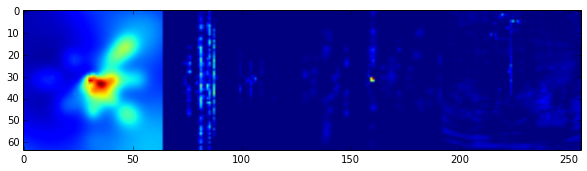

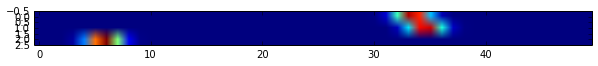

In [21]:
i = 0
plt.figure(figsize=[10,3])
plt.imshow(np.hstack(X[i]))
plt.show()
plt.figure(figsize=[10,3])
plt.imshow(np.vstack(y[i]))
plt.show()

In [22]:
#setup data format
X= X.reshape(-1,*input_shape[1:]).astype('float32')
y = y.reshape(-1,*output_shape[1:]).astype('float32')
print X.shape,y.shape

(27185, 4, 64, 64) (27185, 3, 1, 50)


In [23]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts = train_test_split(X,y,test_size=0.3,random_state=42)

# train it
* by iteratively picking minibatches and training on them
* the method used for iterations is
 * Stochastic Gradient Descent (SGD) updates with Nesterov momentum
 * used it just because i heard it's good, no actual analysis done
* Uniform additive l2 regularization is applied to the network to prevent overfitting as well
 * regularization constant was briefly tweaked via crossvalidation for ROC AUC
 * more sophisticated regularizers were not analyzed

In [24]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [25]:
import random
def show_sample_predictions(X,y,count=10):
    
    #select samples to show
    sample_indices = np.random.randint(0,len(y)-1,count)

    y_pred = predict(X[sample_indices])
    
    y = y[sample_indices]
    y/=np.linalg.norm(y,axis=-1,keepdims=True)
    
    
    for i in range(count):

        plt.figure(figsize=[15,2])
        plt.imshow(y[i].reshape(-1,50),interpolation='none')
        plt.title('sample %i reference'%sample_indices[i])
        plt.colorbar()
        plt.show()

        plt.figure(figsize=[15,2])
        plt.imshow(y_pred[i].reshape(-1,50),interpolation='none')
        plt.title('sample %i prediction'%sample_indices[i])
        plt.colorbar()
        plt.show()

In [26]:
#global epoch counter (useful if several train loops were started in succession)
epochCounter = 0
train_scores = {}
test_scores = {}

train loss during epoch 73 : 22.222794
train loss during epoch 74 : 22.229233
train loss during epoch 75 : 22.224838
-------------------------
epoch 2/200, 75 total

layer RMS:
	dense0.W : 0.0104444899454
	dense0.b : 0.000327156978225
	channelwise_softmax_dense.x.W : 0.0285465243308
	channelwise_softmax_dense.x.b : 0.0120540455861
	channelwise_softmax_dense.y.W : 0.0284690578358
	channelwise_softmax_dense.y.b : 0.0119410048238
	channelwise_softmax_dense.z.W : 0.0280389424907
	channelwise_softmax_dense.z.b : 0.0134057971181

train score:
full loss: 22.2240047455
detection loss: 22.2240047455
entropy penalty: 0.0
l2 penalty: 0.0



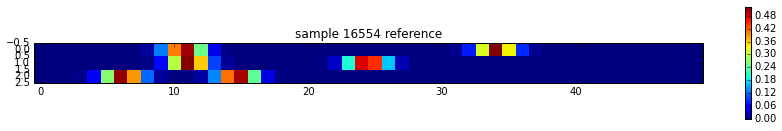

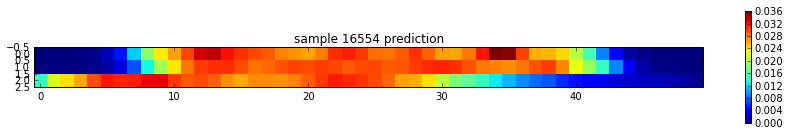

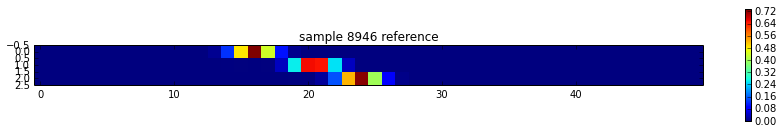

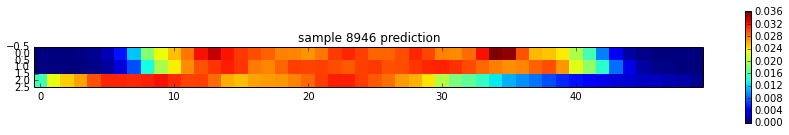

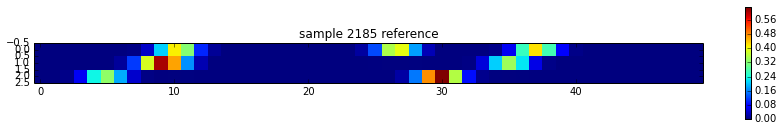

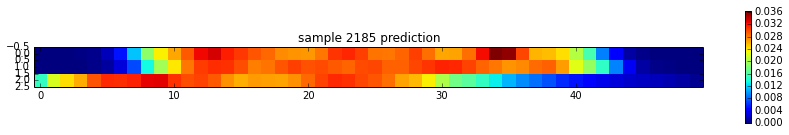

test score:
full loss: 21.8566226959
detection loss: 21.8566226959
entropy penalty: 0.0
l2 penalty: 0.0



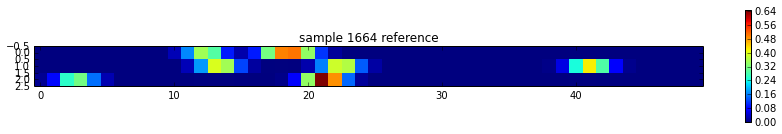

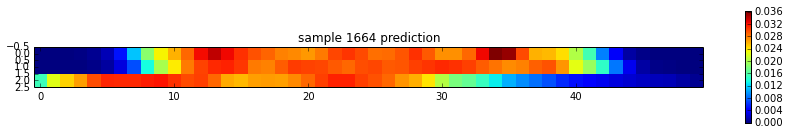

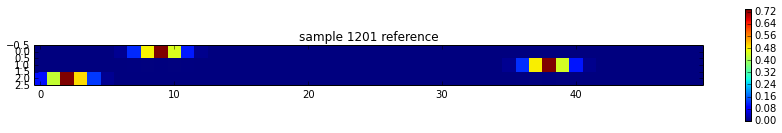

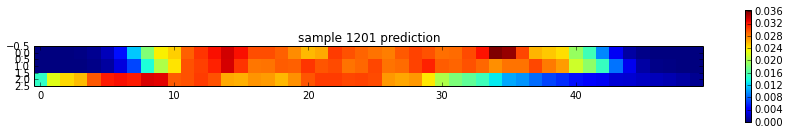

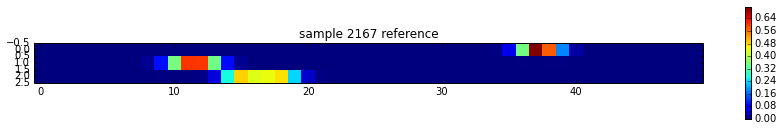

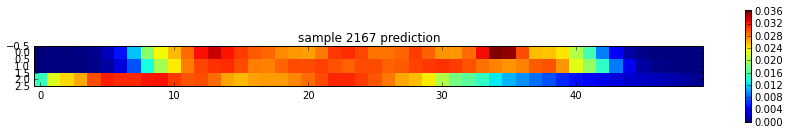

.........................
train loss during epoch 76 : 22.217638
train loss during epoch 77 : 22.214685
train loss during epoch 78 : 22.211115
train loss during epoch 79 : 22.222181
train loss during epoch 80 : 22.212507
train loss during epoch 81 : 22.219559
train loss during epoch 82 : 22.213537
train loss during epoch 83 : 22.211933
train loss during epoch 84 : 22.209034
train loss during epoch 85 : 22.210564
train loss during epoch 86 : 22.209438
train loss during epoch 87 : 22.215492
train loss during epoch 88 : 22.213816
train loss during epoch 89 : 22.208529
train loss during epoch 90 : 22.212839
train loss during epoch 91 : 22.206398
train loss during epoch 92 : 22.216146
train loss during epoch 93 : 22.215090
train loss during epoch 94 : 22.209637
train loss during epoch 95 : 22.209082
train loss during epoch 96 : 22.208632
train loss during epoch 97 : 22.212969
train loss during epoch 98 : 22.205734
train loss during epoch 99 : 22.193886
train loss during epoch 100 : 22.20834

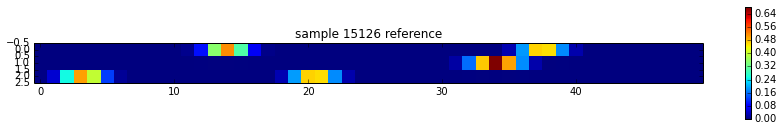

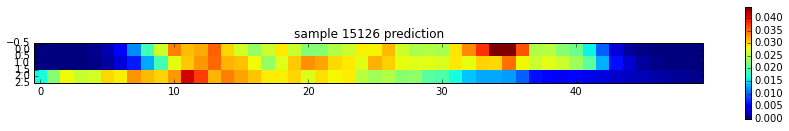

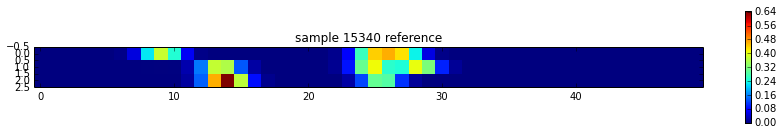

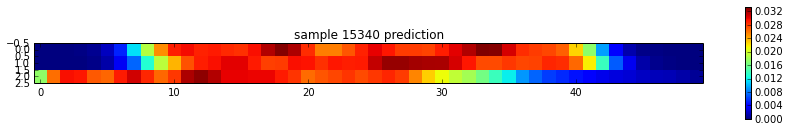

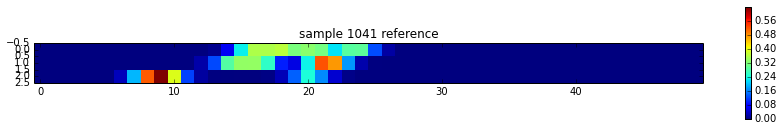

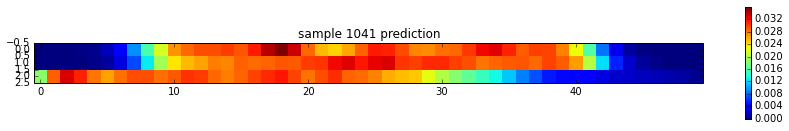

test score:
full loss: 21.8527011871
detection loss: 21.8527011871
entropy penalty: 0.0
l2 penalty: 0.0



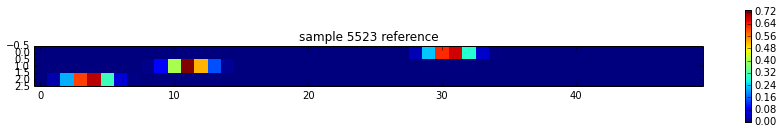

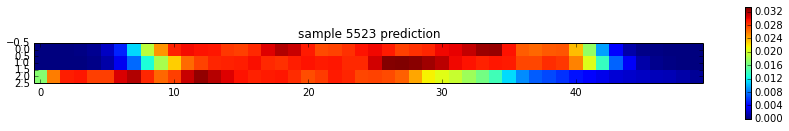

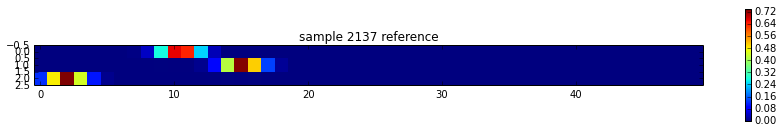

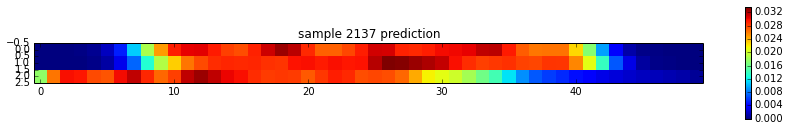

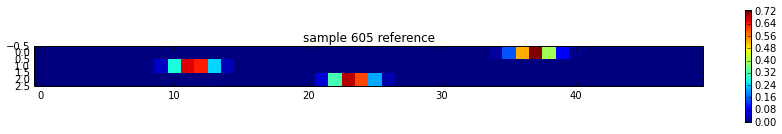

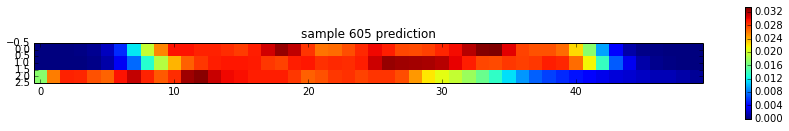

.........................


KeyboardInterrupt: 

In [29]:
n_epochs= 200
batch_size = 500
for i in range(n_epochs):
    err=[]
    for (batch_X,batch_y) in iterate_minibatches(Xtr,Ytr,batch_size,shuffle=True):
        err.append(train_fun(batch_X,batch_y))
    
    
    print 'train loss during epoch %i : %f'%(epochCounter,np.mean(err))
    if epochCounter%25==0:
        print '-'*25
        print 'epoch {}/{}, {} total'.format(i,n_epochs,epochCounter)
        print
        
        print "layer RMS:"
        for param in _nn_weights:
            RMS_weights = (param.get_value()**2).mean()**.5
            print '\t',param,':',RMS_weights
        print
        
        
        
        print 'train score:'
        train_scores[epochCounter] = evaluate(Xtr,Ytr)
        print
        
        show_sample_predictions(Xtr,Ytr,count=3)

        print 'test score:'
        test_scores[epochCounter] = evaluate(Xts,Yts)
        print
        show_sample_predictions(Xts,Yts,count=3)
        print '.'*25
    
    epochCounter+=1



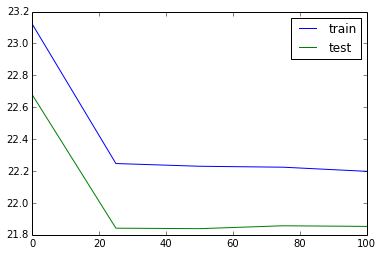

In [30]:
keys,values = zip(*sorted(train_scores.items()))
values = np.hstack(values)
plt.plot(keys,values,label="train")
keys,values = zip(*sorted(test_scores.items()))
values = np.hstack(values)
plt.plot(keys,values,label="test")
plt.legend()

#plt.xlim(0,200)

plt.show()



In [35]:
#2try: two separate training algos (updates) for network and discriminator, 
#each of them updating only a part of network weights. 
#The generator updates from discriminator function can have negative learning rate OR just a minus somewhere along the path


#also try to find out whether gradient updates are indeed opposite in case reversal layer is there
_domain_update.eval({
        _input_image_pair:Xtr,
        _target:Ytr,
    })

NameError: name '_domain_update' is not defined

# Final evaluation

Final scores on the training set:
full loss: 18.3177852631
detection loss: 18.3177852631
entropy penalty: 0.0
l2 penalty: 0.0


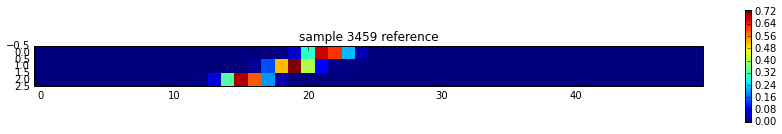

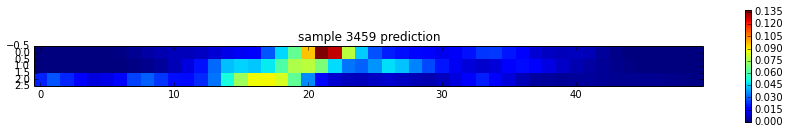

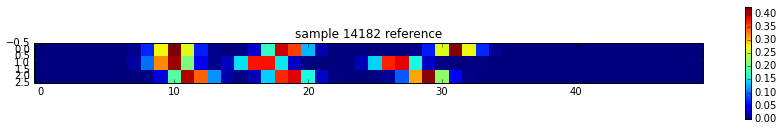

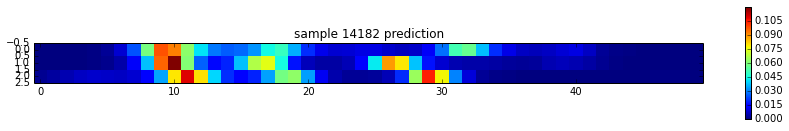

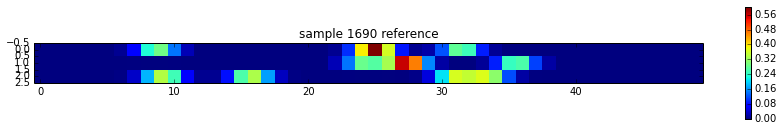

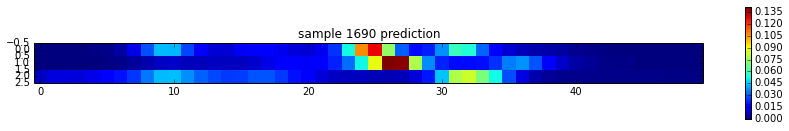

Final scores on the test set:
full loss: 24.349489212
detection loss: 24.349489212
entropy penalty: 0.0
l2 penalty: 0.0


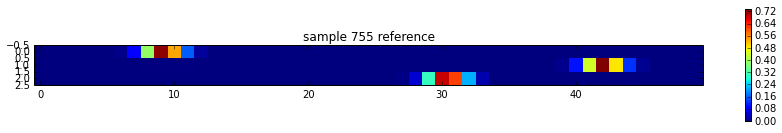

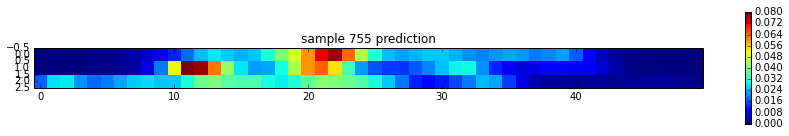

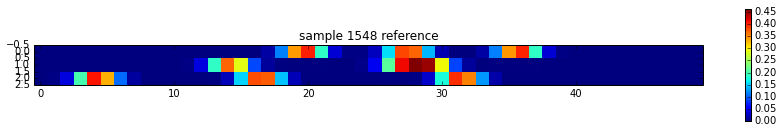

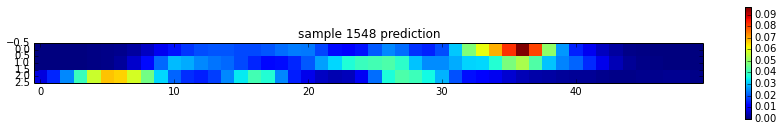

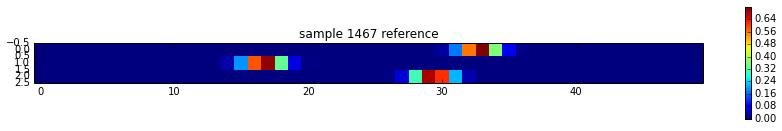

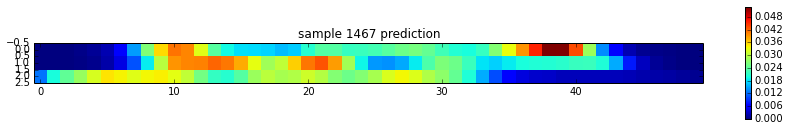

In [54]:
print "Final scores on the training set:"
evaluate(Xtr,Ytr)

show_sample_predictions(Xtr,Ytr,3)

print "Final scores on the test set:"
evaluate(Xts,Yts)

show_sample_predictions(Xts,Yts,3)

# brief conclusion
TODO

In [ ]:
# here the notebook ends

In [ ]:
ww = _nn_weights[0].get_value().T.reshape(-1,64,32)

In [ ]:
from random import choice
i = choice(range(100))
plt.figure(figsize=[7,14])
plt.imshow(ww[i],cmap='bone')
plt.colorbar()
print i


# gradient reversal trick
used here to make network output more like the actual activation map

In [31]:
prefix = "discriminator."

_reference_input_layer = lasagne.layers.InputLayer(shape = output_shape,name='reference',
                                input_var=_target)

#add reverse grad layer on top of the main nn
_disc_nn = ReverseGradientLayer(_nn,1.,
                                      name=prefix+'reversal_layer')


#mix predicted and reference activations
_disc_nn = lasagne.layers.concat([_disc_nn,_reference_input_layer],axis=1)
_disc_nn = lasagne.layers.reshape(_disc_nn,[-1]+output_shape[1:])
#now the predicted and reference activation pics are intertwined (pred,ref,pred,ref,...)




#maybe a convnet here?
_disc_nn = lasagne.layers.DenseLayer(_disc_nn,128,
                                           name=prefix+"dense0",
                                           nonlinearity=lasagne.nonlinearities.tanh)
_disc_nn = lasagne.layers.DenseLayer(_disc_nn,1,
                                           name = prefix+"output",
                                           nonlinearity=lasagne.nonlinearities.sigmoid)





In [32]:
_domain_prediction  = lasagne.layers.get_output(_disc_nn)


In [33]:
_domain_reference = T.repeat(T.constant(np.array([[1,0]])),_target.shape[0],axis=0)
_domain_reference = _domain_reference.reshape([-1,1])


_domain_loss = lasagne.objectives.categorical_crossentropy(_domain_prediction,_domain_reference).mean()



In [34]:
_all_weights = lasagne.layers.get_all_params(_disc_nn, trainable = True)
_disc_weights = [param for param in _all_weights if param not in _nn_weights]

_disc_weights


[discriminator.dense0.W,
 discriminator.dense0.b,
 discriminator.output.W,
 discriminator.output.b]

In [ ]:
#try out binary crossentropy for mail NN? - after finding out how exactly it is computed
_domain_update = lasagne.updates.nesterov_momentum(_domain_loss,
                                               params = _all_weights,
                                               learning_rate = .01
                                              )



In [ ]:
# compiled optimization algorithm
domain_train_fun = theano.function([_input_image_pair,_target],
                            _domain_loss,
                            updates=_domain_update,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )



In [ ]:
n_epochs= 500
batch_size = 500
for i in range(n_epochs):
    err=[]
    for (batch_X,batch_y) in iterate_minibatches(Xtr,Ytr,batch_size,shuffle=True):
        err.append(domain_train_fun(batch_X,batch_y))
    
    
    print 'train loss: ',np.mean(err)
    if epochCounter%25==0:
        print '-'*25
        print 'epoch {}/{}, {} total'.format(i,n_epochs,epochCounter)
        print
        
        print "layer RMS:"
        for param in _nn_weights:
            RMS_weights = (param.get_value()**2).mean()**.5
            print '\t',param,':',RMS_weights
        print
        
        
        
        show_sample_predictions(Xtr,Ytr,count=3)
    
    epochCounter+=1

